In [1]:
import os
from glob import glob
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.plotting import plot_trajectory
from utils.processing import (
    normalize_angles_2pi,
    open_file,
    cut_jumps
    )

DATA_DIR = 'dataset'
PREPROC_DATA_DIR = 'preprocessed_dataset'

# Preprocessing

In [2]:
## Sequence of preproc:
# 1. open files
# 2. cut_jumps
# 3. rescale x and y coords to fit area size 
# 4. divide trajectories into sub-trajectories to remove inconsistent dt and Nans
# 5. resample to required dt
# 6. add angles, delta_angles, step len, 
# 7. save to .csv? to h5?

# TODO: all preprocessing params should be gathered in one place (notebook cell or config file)

In [3]:
# 1. open files
dataset_names = sorted(glob(os.path.join(DATA_DIR, '*.txt')))
datasets = {}
for nam in dataset_names:
    k = Path(nam).stem
    v = open_file(nam, show=False)
    datasets[k] = v

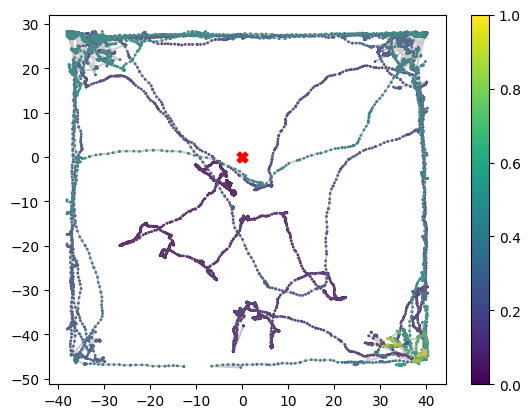

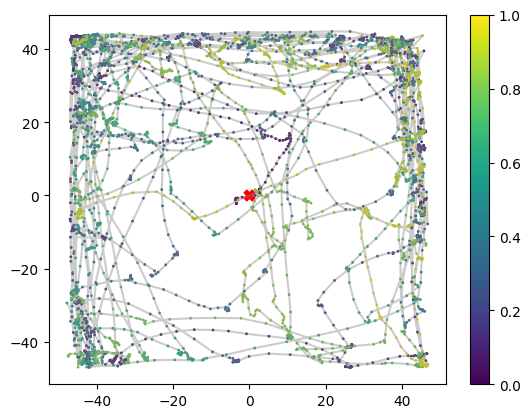

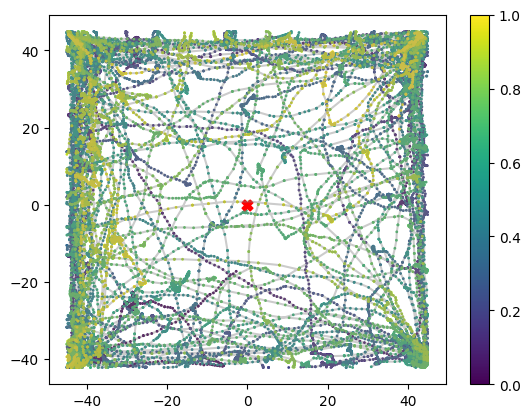

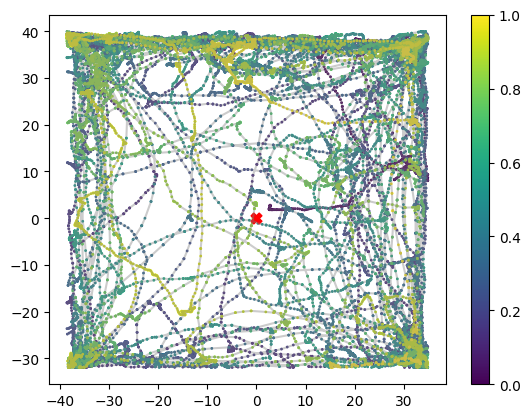

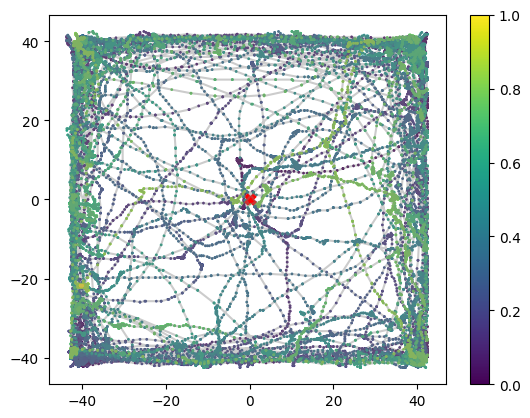

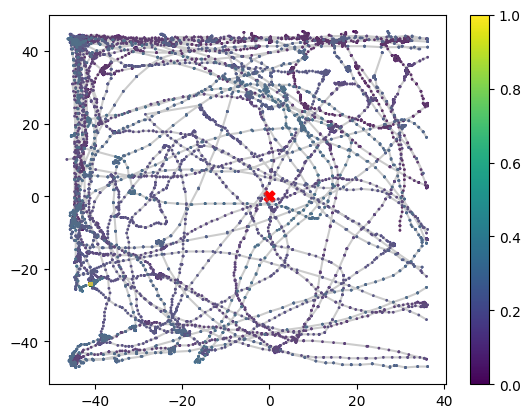

In [4]:
# 2. cut_jumps
tr11 = datasets['Trace_1.1']  # TODO: params to config
tr12 = datasets['Trace_1.2']  
tr2 = datasets['Trace_2']
tr5 = datasets['Trace_5']

tr4 = cut_jumps(datasets['Trace_4'], xmax=40.4, xmin=-38.1, ymax=28.3, ymin=-47.6)
tr3 = cut_jumps(datasets['Trace_3'], xmax=46.8, xmin=-48, ymax=46, ymin=-47)
tr6 = cut_jumps(datasets['Trace_6'], xmax=45, xmin=-45, ymax=45, ymin=-42.2)
tr7 = cut_jumps(datasets['Trace_7'], xmax=35, xmin=-38.7, ymax=40, ymin=-32)
tr91 = cut_jumps(datasets['Trace_9.1'], xmax=42.5, xmin=-43.7, ymax=42.5, ymin=-42.7)
tr92 = cut_jumps(datasets['Trace_9.2'], xmax=36.3, xmin=-46.5, ymax=45.4, ymin=-47.3)

In [5]:
dfs = [tr11, tr12, tr2, tr3, tr4, tr5, tr6, tr7, tr91, tr92]
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

dfs_dict = {}
for k, val in zip(dfs_names, dfs):
    dfs_dict[k] = val

In [6]:
# 3. rescale x and y coords to fit area size 
def rescale_coord(data, new_min, new_max):
    min_old_x, max_old_x = np.min(data), np.max(data)
    data_rescaled = ((data - min_old_x) / (max_old_x - min_old_x)) * (new_max - new_min) + new_min
    return data_rescaled

AREA_SIZE = [-40, 40]
rescaled_dfs_dict = {}
for k, df in dfs_dict.items():
    df = df.dropna()
    rescaled_x = rescale_coord(df['x'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
    rescaled_y = rescale_coord(df['y'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
    df.loc[:, 'x'] = rescaled_x
    df.loc[:, 'y'] = rescaled_y

    rescaled_dfs_dict[k] = df

    # plot_trajectory(df['x'], df['y'])
    # print(df.min(), df.max())

In [7]:
# 4. divide trajectories into sub-trajectories to remove inconsistent dt and Nans
def divide_traj_by_nans(df, k, dt_threshold, traj_drop_threshold=5):
    # 1. Drop Nans
    df = df.dropna()
    # 2. Find if any time jumps
    dt_times = df['time'].diff().to_numpy()
    dt_times[0] = 0.
    div_idx = np.where(dt_times > dt_threshold)[0]
    div_idx = np.asarray(div_idx)

    # 3. Divide by time jumps
    if len(div_idx) > 0:
        div_idx = np.concatenate([np.array([0]),
                                  div_idx,
                                  np.array([len(df)])])
        sub_trajectories = []
        start_i = div_idx[0]
        for end_i in div_idx[1:]:
            if end_i - start_i > traj_drop_threshold:
                sub_df = df[start_i:end_i]
                sub_trajectories.append(sub_df)
            start_i = end_i + 1

        return k, sub_trajectories
    else:
        return k, [df]
    
DROP_THRESHOLD = 5
dt_thresholds = {'tr11': 0.035, 'tr12': 0.035, 'tr2': 0.035, 'tr3': 0.135,  # TODO: to configs
                 'tr4': 0.035,  'tr5': 0.035, 'tr6': 0.035, 'tr7': 0.035,
                 'tr91': 0.035, 'tr92': 0.035}

subtraj_dfs_dict = {}
for k, df in rescaled_dfs_dict.items():
    k, df_subtraj= divide_traj_by_nans(df, k, dt_threshold=dt_thresholds[k],
                                       traj_drop_threshold=DROP_THRESHOLD)
    subtraj_dfs_dict[k] = df_subtraj  # list of dfs

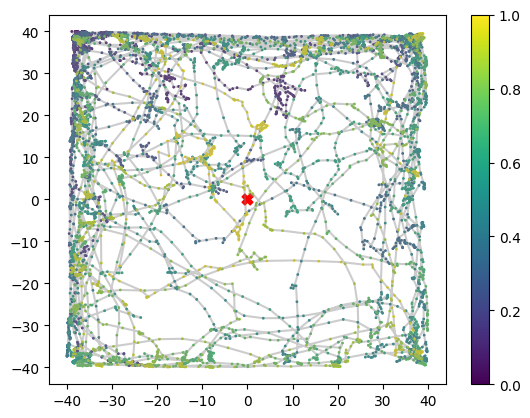

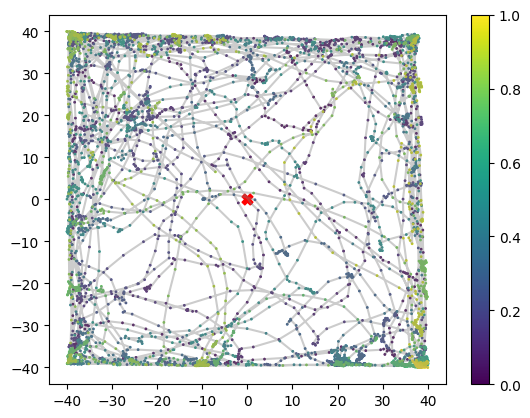

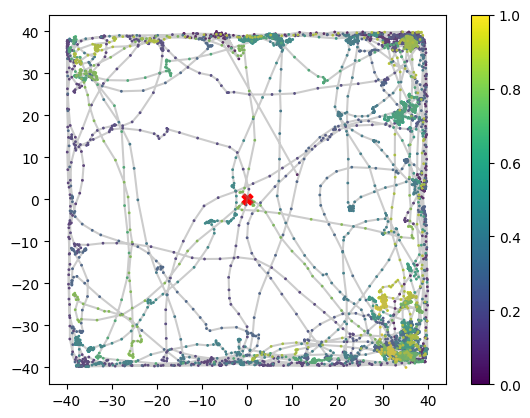

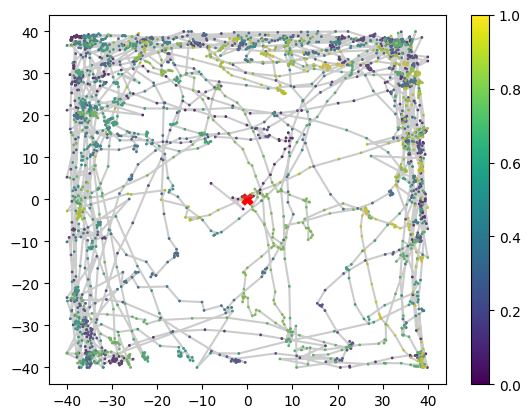

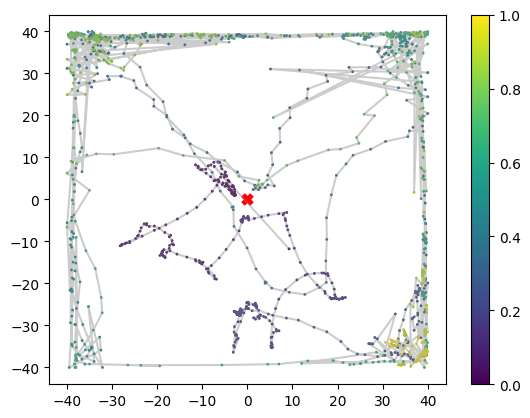

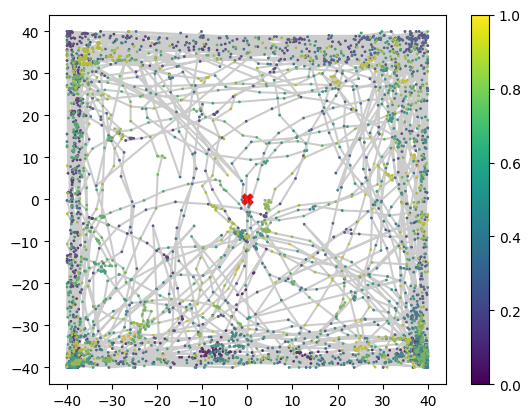

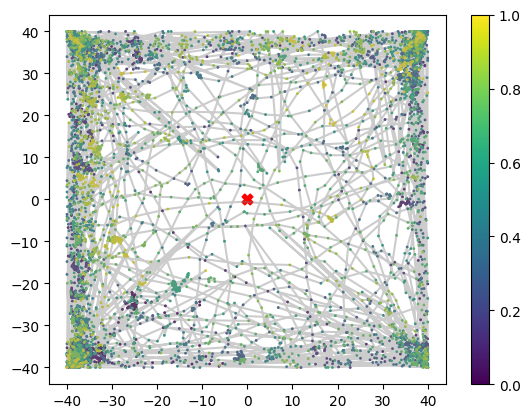

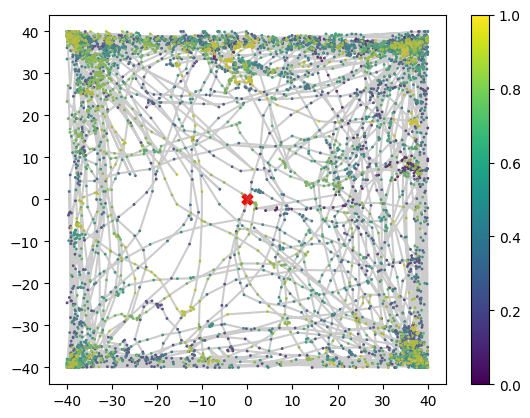

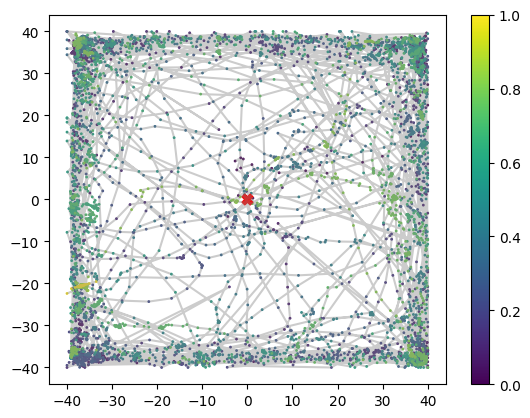

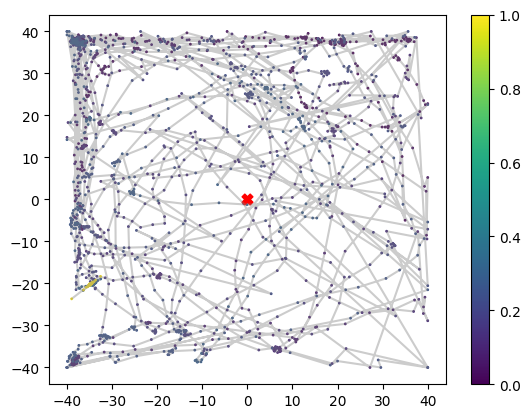

In [8]:
# 5. resample to required dt
def resample_data_to_larger_timestep(df, original_dt, new_dt):
    from scipy.signal import resample

    num_original_points = df.shape[0]
    duration = num_original_points * original_dt
    num_new_points = int(duration / new_dt)
    
    resampled_dfnp = resample(df.to_numpy()[:, 1:], num_new_points, axis=0)
    new_time = np.linspace(df['time'].iloc[0], df['time'].iloc[-1], num_new_points)

    resampled_df = pd.DataFrame({'time': new_time,
                                 'x': resampled_dfnp[:, 0], 
                                 'y': resampled_dfnp[:, 1]})
    
    # We normalize samples that are not in range AREA_SIZE=[-40, 40]
    # which are resampling artefacts
    resampled_df['x'].loc[resampled_df['x'] >  40.] = 40.
    resampled_df['x'].loc[resampled_df['x'] < -40.] = -40.
    resampled_df['y'].loc[resampled_df['y'] >  40.] = 40.
    resampled_df['y'].loc[resampled_df['y'] < -40.] = -40.

    return resampled_df


# # NOTE: We ignore that there are TWO most frequent dt-s: 0.033 and 0.034
# ORIGINAL_DT = {'tr11': 0.034, 'tr12': 0.034, 'tr2': 0.034, 'tr3': 0.134,
#                'tr4': 0.034, 'tr5': 0.034, 
#                'tr6': 0.034, 'tr7': 0.034, 'tr91': 0.034, 'tr92': 0.034}
ORIGINAL_DT = {'tr11': 0.0335, 'tr12': 0.0335, 'tr2': 0.0335, 'tr3': 0.1335,  # TODO: to configs
               'tr4': 0.0335, 'tr5': 0.0335, 
               'tr6': 0.0335, 'tr7': 0.0335, 'tr91': 0.0335, 'tr92': 0.0335}
NEW_DT = 0.2

# TODO: raw version! need to concat for better resampling
resampled_subtraj_dfs_dict = {}
for k, df in subtraj_dfs_dict.items():
    subtraj_list = []
    for sub_traj_df in df:
        resampled_sub_traj_df = resample_data_to_larger_timestep(sub_traj_df,
                                                                    ORIGINAL_DT[k],
                                                                    NEW_DT)
        subtraj_list.append(resampled_sub_traj_df)
    resampled_subtraj_dfs_dict[k] = subtraj_list

    ff = pd.concat(subtraj_list)
    plot_trajectory(ff['x'], ff['y'])

In [ ]:
#=========TODO===============================================

[[1.001, 1754.987]]


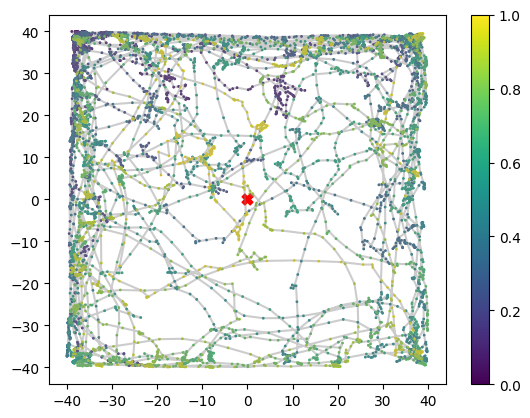

-----
[[1.001, 753.119], [753.253, 1516.582], [1516.715, 1520.119], [1521.553, 1754.987]]


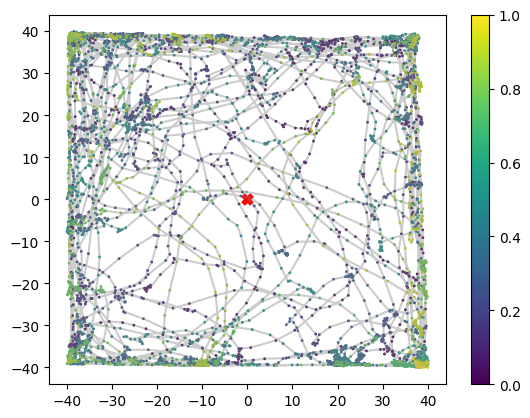

-----
[[10.01, 1754.987]]


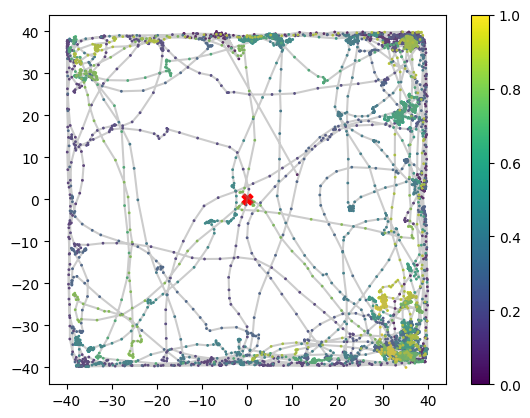

-----
[[1.001, 8.609], [25.425, 26.493], [30.497, 35.836], [72.139, 74.274], [105.639, 106.974], [186.386, 191.324], [218.151, 224.424], [224.958, 227.36], [228.161, 232.032], [234.167, 236.837], [238.972, 244.711], [245.245, 246.179], [249.249, 252.719], [369.102, 370.036], [370.57, 371.638], [373.773, 379.379], [382.315, 387.787], [388.588, 389.656], [390.457, 392.592], [394.728, 400.6], [401.134, 401.935], [402.469, 411.278], [437.17, 441.441], [444.511, 450.25], [452.118, 456.79], [457.59, 460.527], [463.196, 473.473], [520.587, 521.521], [522.188, 524.724], [527.394, 535.268], [539.139, 544.611], [547.28, 561.027], [561.428, 562.896], [565.832, 571.838], [572.372, 596.529], [600.133, 608.408], [609.075, 611.211], [612.145, 613.079], [617.35, 619.886], [620.954, 637.237], [640.974, 645.778], [646.312, 648.848], [654.187, 659.926], [660.326, 678.478], [678.878, 687.153], [688.621, 689.289], [693.026, 711.711], [714.647, 715.315], [718.918, 722.121], [755.088, 770.303], [771.904, 775

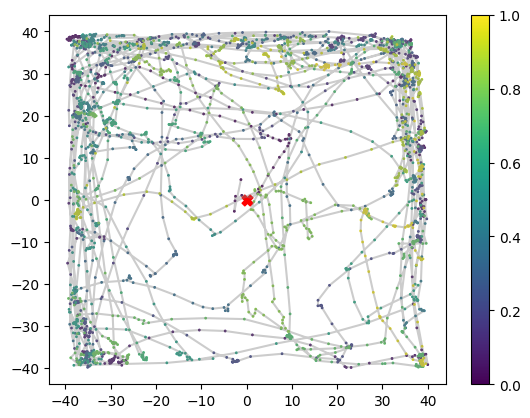

-----
[[1.001, 67.801], [67.968, 68.902], [69.036, 69.269], [69.469, 73.507], [74.541, 77.344], [78.912, 84.985], [86.787, 96.63], [97.064, 97.864], [98.365, 103.904], [104.404, 108.308], [109.209, 110.043], [110.31, 110.644], [110.811, 117.117], [117.417, 117.618], [118.151, 119.052], [119.252, 122.089], [122.222, 124.625], [124.958, 125.225], [125.459, 134.635], [134.968, 135.135], [135.302, 136.503], [142.409, 143.71], [143.877, 145.212], [145.312, 145.912], [146.713, 146.913], [148.448, 149.216], [149.516, 151.652], [152.252, 152.719], [152.853, 157.691], [159.192, 160.16], [161.428, 163.897], [164.765, 166.033], [168.068, 170.203], [171.972, 174.207], [175.375, 177.01], [177.878, 178.378], [181.915, 183.05], [183.483, 187.754], [189.656, 191.458], [191.958, 192.292], [192.392, 192.592], [193.093, 195.896], [196.63, 202.669], [202.903, 204.371], [204.905, 213.947], [214.281, 214.481], [214.748, 215.182], [215.315, 229.229], [230.731, 230.897], [232.165, 234.468], [234.968, 235.135]

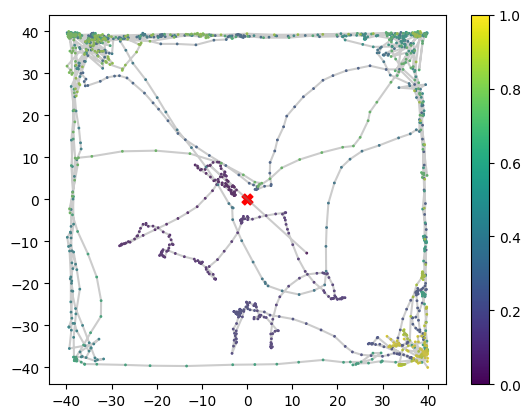

-----
[[1.001, 8.809], [9.276, 30.898], [31.064, 35.736], [36.336, 49.216], [50.217, 50.551], [51.118, 54.054], [54.821, 55.188], [55.289, 88.522], [88.822, 90.591], [128.328, 128.996], [131.365, 133.533], [134.067, 134.434], [134.568, 135.469], [137.037, 138.639], [174.975, 175.208], [175.308, 175.509], [182.115, 182.416], [183.55, 184.451], [184.918, 196.697], [198.065, 202.703], [203.637, 209.71], [210.377, 211.912], [212.079, 212.479], [213.146, 225.992], [226.827, 227.661], [228.428, 228.595], [228.929, 231.798], [232.099, 233.834], [234.334, 235.902], [236.002, 237.304], [237.404, 237.671], [239.106, 239.372], [241.608, 244.511], [252.052, 252.586], [252.686, 253.887], [258.725, 270.303], [270.57, 283.183], [283.55, 288.855], [289.322, 292.359], [294.361, 300.5], [300.6, 306.173], [306.439, 311.444], [312.145, 317.484], [317.918, 320.821], [327.06, 329.329], [329.696, 330.163], [330.33, 334.668], [336.269, 346.112], [346.279, 346.78], [347.848, 349.683], [350.383, 350.684], [354.

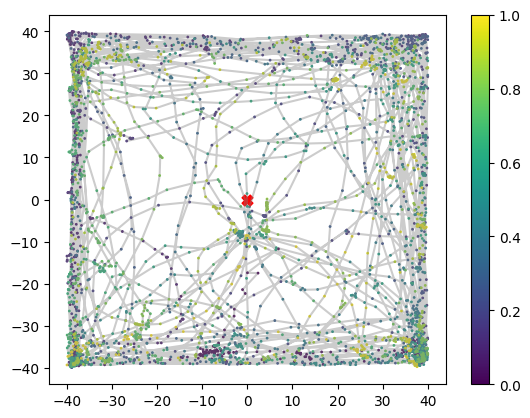

-----
[[1.001, 88.121], [88.322, 211.578], [211.945, 223.49], [226.293, 229.029], [229.596, 291.224], [291.725, 304.905], [305.906, 307.641], [308.909, 310.71], [312.145, 327.127], [327.928, 332.299], [333.366, 345.245], [345.879, 348.415], [348.949, 364.931], [365.565, 366.333], [367.167, 374.608], [375.108, 376.142], [378.111, 435.368], [438.038, 453.42], [454.087, 460.46], [462.195, 467.2], [467.467, 496.229], [497.33, 502.869], [504.337, 551.251], [551.818, 562.062], [562.529, 566.966], [567.2, 573.74], [574.074, 576.609], [576.776, 607.64], [608.308, 622.755], [622.989, 626.693], [627.36, 629.295], [629.529, 630.563], [631.364, 638.171], [640.24, 644.31], [648.314, 653.887], [653.987, 665.165], [665.899, 686.986], [687.22, 691.491], [691.758, 692.258], [693.159, 698.932], [699.699, 702.969], [703.636, 710.643], [711.277, 722.689], [723.089, 732.632], [732.799, 733.333], [733.633, 744.244], [745.345, 747.647], [748.114, 751.818], [752.118, 766.099], [766.966, 772.238], [772.505, 78

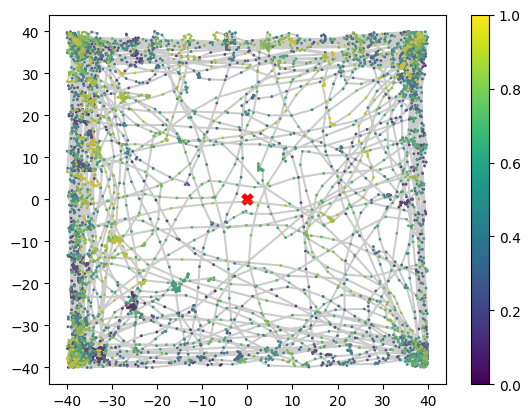

-----
[[1.001, 76.81], [77.544, 182.849], [183.45, 205.639], [206.506, 209.443], [210.41, 214.614], [215.115, 217.884], [218.985, 228.929], [229.896, 232.833], [232.999, 233.2], [233.5, 234.367], [235.102, 284.785], [285.552, 296.897], [297.063, 330.931], [331.998, 342.576], [342.676, 347.681], [347.914, 366.166], [366.8, 368.301], [369.002, 394.861], [395.061, 428.929], [429.729, 433.333], [434.1, 434.301], [435.669, 436.503], [438.805, 441.541], [442.709, 442.943], [443.143, 444.277], [446.88, 454.621], [455.722, 460.293], [460.393, 462.896], [464.197, 506.272], [506.506, 506.94], [507.841, 508.074], [508.241, 509.075], [509.476, 509.642], [509.743, 510.21], [510.543, 522.222], [523.356, 526.126], [527.961, 530.163], [531.631, 535.468], [535.835, 554.754], [554.888, 567.133], [570.97, 625.158], [625.725, 625.892], [627.16, 680.78], [682.148, 709.576], [710.677, 754.754], [756.389, 759.092], [762.495, 765.231], [767.133, 773.406], [773.873, 774.04], [774.173, 804.203], [804.604, 814.1

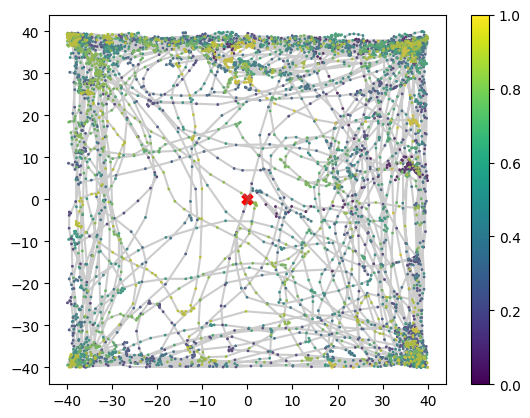

-----
[[1.001, 5.172], [5.272, 20.12], [20.354, 40.641], [42.109, 43.877], [44.912, 84.851], [85.252, 86.286], [86.42, 102.336], [102.469, 148.715], [149.783, 163.864], [164.131, 168.769], [169.036, 190.791], [191.758, 217.15], [217.317, 224.925], [225.092, 225.358], [225.726, 226.026], [226.159, 228.128], [228.228, 289.289], [289.856, 291.625], [291.792, 292.826], [293.794, 314.714], [315.215, 319.986], [321.721, 324.991], [325.225, 326.493], [326.96, 370.57], [370.971, 376.243], [377.244, 377.477], [378.044, 411.411], [411.878, 461.861], [462.128, 534.401], [534.601, 588.354], [589.255, 598.331], [598.565, 681.047], [681.981, 688.755], [688.855, 689.022], [689.522, 689.789], [690.256, 705.772], [705.872, 759.125], [759.259, 770.937], [771.104, 810.243], [810.343, 815.615], [815.715, 867.934], [868.234, 895.628], [895.828, 901.033], [901.934, 907.64], [907.94, 984.317], [984.784, 985.384], [985.785, 1018.818], [1019.218, 1041.307], [1042.542, 1045.578], [1046.012, 1050.116], [1050.95,

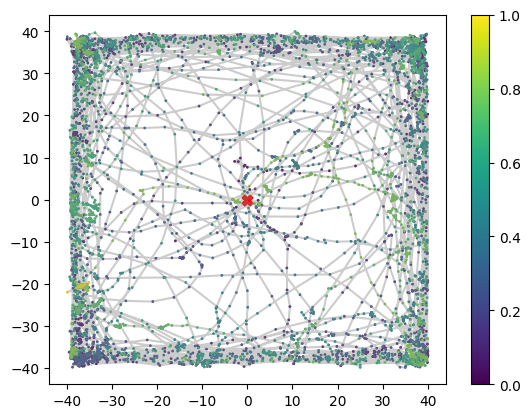

-----
[[1.001, 3.003], [4.071, 6.206], [6.64, 6.807], [7.207, 8.242], [8.642, 8.942], [9.409, 9.643], [10.11, 10.577], [11.011, 14.147], [15.015, 29.73], [29.963, 46.813], [47.114, 70.07], [70.971, 138.572], [145.646, 177.477], [182.215, 192.192], [192.492, 192.793], [197.264, 202.102], [203.103, 205.739], [206.44, 211.878], [212.145, 224.891], [230.097, 278.745], [372.372, 374.407], [386.486, 402.936], [403.236, 444.878], [445.412, 450.15], [450.45, 451.451], [451.818, 452.085], [452.552, 452.953], [453.42, 458.959], [461.194, 466.299], [471.838, 480.513], [480.814, 481.448], [504.704, 507.34], [507.574, 511.011], [519.085, 542.142], [542.675, 563.563], [564.03, 579.345], [579.679, 593.927], [594.227, 610.91], [611.277, 611.544], [642.542, 1678.977]]


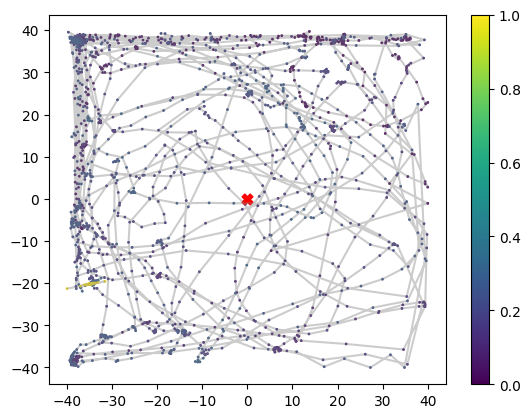

-----


In [114]:
# TODO more artefact free resampling  

resampled_subtraj_dfs_dict = {}
for k, df in subtraj_dfs_dict.items():
    
    # 1. concat all together, reindex, save old times
    old_times_ranges = [[traj['time'].iloc[0], traj['time'].iloc[-1]] for traj in df]
    print(old_times_ranges)

    concat_df = pd.concat(df)
    # print(concat_df.shape)

    old_times = concat_df['time'].copy()
    old_lens = [d.shape[0] for d in df]
    # concat_df = concat_df.reset_index(drop=True)

    # 2. resample and divide to subraj again
    resampled_df = resample_data_to_larger_timestep(concat_df,
                                                    ORIGINAL_DT[k],
                                                    NEW_DT)
    # print(resampled_df.shape)
    # subtraj_list = []
    # for subtraj_time in old_times_ranges:

        # find idx of time closest to subtraj_time[0]
        # the same for subtraj_time[1]
        # cut and append to subtraj_list.append()
        # new times with 
        # new_time = np.linspace(df['time'].iloc[0], df['time'].iloc[-1], num_new_points)
        # sidx = subtraj_time[0]
        # eidx = subtraj_time[1]
        # resampled_df.iloc[sidx, eidx]

    # resampled_subtraj_dfs_dict[k] = subtraj_list
    plot_trajectory(resampled_df['x'], resampled_df['y'])
    print('-----')

In [118]:
# [[1.001, 3.003], [4.071, 6.206], [6.64, 6.807]
resampled_df.iloc[5:15]

time          x          y
5   2.139074  30.858293  22.212916
6   2.366689  25.620302  26.797804
7   2.594303  26.045783  30.057947
8   2.821918  22.949442  32.070746
9   3.049533  25.506750  30.813984
10  3.277148  21.247927  34.013699
11  3.504762  16.610874  38.389350
12  3.732377  15.713153  36.860553
13  3.959992  16.193350  37.585681
14  4.187607  15.550459  37.390281

In [122]:
concat_df.iloc[122:130]

time          x          y
131  6.106  15.460331  38.465644
132  6.139  15.460331  38.465644
133  6.173  15.460331  38.465644
134  6.206  15.460331  38.465644
137  6.640  12.515183  38.027381
138  6.673  12.515183  38.027381
139  6.707  12.515183  38.027381
140  6.740  12.515183  38.685209

In [ ]:
#=========TODO===============================================

In [8]:
# Resampled time check
# tes = resampled_subtraj_dfs_dict['tr3']
# for i in range(5):
    # plt.plot(tes[i]['time'].to_numpy())
    # plt.show()

In [9]:
# 6. add angles, delta_angles, step len, 
def add_angles(df):
    dt = df['time'].diff()
    vvx = df['x'].diff() / dt 
    vvy = df['y'].diff() / dt 
    dt[0], vvx[0], vvy[0] = 0., 0., 0.

    Xx = np.arctan2(vvx, vvy)
    Nres = normalize_angles_2pi(Xx)
    ang = np.rad2deg(Nres) % 360
    df['angles'] = ang
    return df

def add_delta_angles(df):
    dangles = df['angles'].diff()
    dangles[0] = 0.
    dangles_rad = np.deg2rad(dangles)
    normed_dangels_rad = normalize_angles_2pi(dangles_rad)
    df['delta_angle'] = np.rad2deg(normed_dangels_rad) % 360
    return df

def add_step_length(df):
    dx = df['x'].diff()
    dy = df['y'].diff()
    dx[0], dy[0] = 0., 0.,
    step_lens = (dx**2 + dy**2)**0.5
    df['step_length'] = step_lens
    return df


dfs_dict_with_angles = {}
for k, df in resampled_subtraj_dfs_dict.items():
    subtraj_list = []
    for sub_traj_df in df:
        df_ang = add_angles(sub_traj_df)
        df_dt_ang = add_delta_angles(df_ang)
        df_step = add_step_length(df_dt_ang)
        subtraj_list.append(df_step)
    dfs_dict_with_angles[k] = subtraj_list

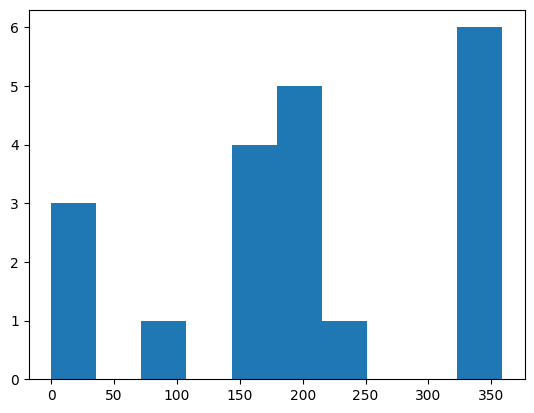

time          x         y      angles  delta_angle  step_length
0  228.161000  39.678289 -5.743013    0.000000     0.000000     0.000000
1  228.364737  39.502833  1.310587  358.575082   358.575082     7.055782
2  228.568474  39.439961 -0.387720  182.120162   183.545079     1.699471
3  228.772211  39.420995 -0.060215  356.685698   174.565536     0.328054
4  228.975947  39.481892  0.189621   13.698555    17.012857     0.257151

In [10]:
dftes = dfs_dict_with_angles['tr3'][8]
plt.hist(dftes['delta_angle'].to_numpy())
plt.show()
dftes.head(5)

In [11]:
# 7. save to pickle
import pickle
PREPROC_DATA_DIR = 'preprocessed_dataset'

def save_preprocessed_data(sub_trajs_list, k):
    if type(sub_trajs_list) != list:
        raise ValueError('Should be a list!')

    fname = os.path.join(PREPROC_DATA_DIR, f'{k}.pkl')
    with open(fname, 'wb') as outp:
        pickle.dump(sub_trajs_list, outp, pickle.HIGHEST_PROTOCOL)
    print(f'Successfully saved {k} as {fname}')


for k, df in dfs_dict_with_angles.items():
    save_preprocessed_data(df, k)

Successfully saved tr11 as preprocessed_dataset/tr11.pkl
Successfully saved tr12 as preprocessed_dataset/tr12.pkl
Successfully saved tr2 as preprocessed_dataset/tr2.pkl
Successfully saved tr3 as preprocessed_dataset/tr3.pkl
Successfully saved tr4 as preprocessed_dataset/tr4.pkl
Successfully saved tr5 as preprocessed_dataset/tr5.pkl
Successfully saved tr6 as preprocessed_dataset/tr6.pkl
Successfully saved tr7 as preprocessed_dataset/tr7.pkl
Successfully saved tr91 as preprocessed_dataset/tr91.pkl
Successfully saved tr92 as preprocessed_dataset/tr92.pkl


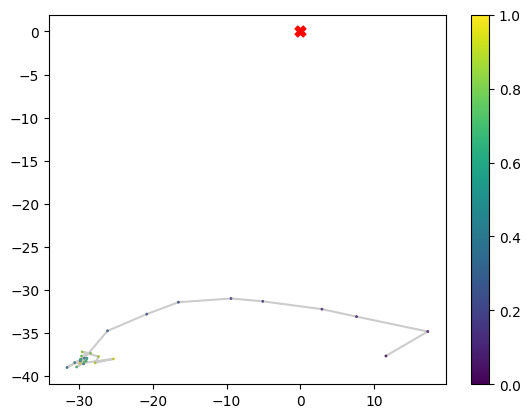

112

In [12]:
# Check that everything works well
def open_preprocessed_data(fname):
    with open(fname, 'rb') as inp:
        sub_trajs_list = pickle.load(inp)
    return sub_trajs_list

sub_traj_df = open_preprocessed_data('preprocessed_dataset/tr3.pkl')
plot_trajectory(sub_traj_df[10]['x'], sub_traj_df[10]['y'])
len(sub_traj_df)

# Develop Funcs

In [5]:
# 1. Find dt tresholds by hands for each traj, save

## 2. Create function:
def divide_traj_by_nans():
    pass
# a. Drop nans
# b. Find places where dt > dt_treshold
# c. Find idxs of start and end of this space period, save them to list 
# d. cut trajectory into subtrajectories by this periods
# e. return original trajectory, cutted subset and list of cuts

# So now we change a bit data structure:
# from {'tr4': df} to {'tr4': [df1, df2, ...]}

# 3. Make resampling function, place it before all other functions, use after def divide_traj_by_nans()

# 4. Find and put into one place all functinos that add new columns to dataframe (angle, dangle, area, etc.)

# 5. Save all preprocessed datasets to work with them further!

# 6. Think how all other functions will operate with new data format

### Find dt tresholds by hands for each traj, save

In [12]:
dfs = [tr11, tr12, tr2, tr3, tr4, tr5, tr6, tr7, tr91, tr92]
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

dfs_dict = {}
for k, val in zip(dfs_names, dfs):
    dfs_dict[k] = val

In [13]:
# Find data that has Nans and how many 
for k, df in dfs_dict.items():
    print(k, df.shape)
    df_dropped = df.dropna()

    dropped_num = df.shape[0] - df_dropped.shape[0]
    print('Dropped samples num: ', dropped_num)
    print('--'*15)

tr11 (52568, 3)
Dropped samples num:  0
------------------------------
tr12 (52523, 3)
Dropped samples num:  0
------------------------------
tr2 (52298, 3)
Dropped samples num:  0
------------------------------
tr3 (6197, 3)
Dropped samples num:  730
------------------------------
tr4 (16755, 3)
Dropped samples num:  6994
------------------------------
tr5 (27369, 3)
Dropped samples num:  0
------------------------------
tr6 (49783, 3)
Dropped samples num:  2492
------------------------------
tr7 (48912, 3)
Dropped samples num:  2945
------------------------------
tr91 (51862, 3)
Dropped samples num:  588
------------------------------
tr92 (46366, 3)
Dropped samples num:  2278
------------------------------


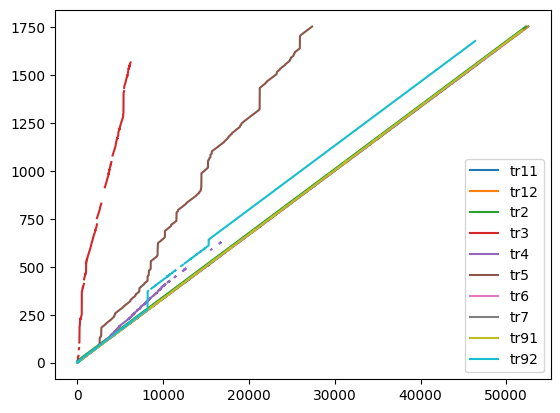

In [14]:
# Look at time steps
for k, df in dfs_dict.items(): 
    dat_times = np.asarray(df['time'].values.tolist())
    plt.plot(dat_times, label=k)
plt.legend()
plt.show()

# We can see, that some trajectories are short, with many Nans and time jumps
# [tr91,tr2,tr12,tr11, tr6, tr7] - normal; [tr92] - almost normal;
# [tr3, tr5, ] - are bad; [tr4] - totaly bad, drop it

In [9]:
# del dfs_dict['tr4'] 
# dfs_dict.keys()

dict_keys(['tr11', 'tr12', 'tr2', 'tr3', 'tr5', 'tr6', 'tr7', 'tr91', 'tr92'])

for:  tr11
Unique:  [0.033 0.034]
Counts:  [33292 19275]
---------------
for:  tr12
Unique:  [0.033 0.034 0.1   1.401]
Counts:  [33261 19258     2     1]
---------------
for:  tr2
Unique:  [0.033 0.034]
Counts:  [33121 19176]
---------------
for:  tr3
Unique:  [  0.133   0.134   0.266   0.267   0.4     0.401   0.533   0.534   0.667
   0.668   0.8     0.801   0.934   0.935   1.067   1.068   1.201   1.202
   1.334   1.335   1.468   1.601   1.602   1.735   1.736   1.868   1.869
   2.002   2.135   2.268   2.269   2.402   2.536   2.803   2.937   3.069
   3.203   3.47    4.138   4.404   4.538   4.671   4.672   5.338   6.406
   7.475  12.412  13.213  14.681  25.225  46.313  53.921 103.97  116.25
     nan]
Counts:  [2816 2472    1   18   13   15    1   10    9    2    4    6    5    2
    1    1    4    2    1    1    2    3    2    3    1    1    1    4
    1    1    1    1    3    4    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1  764]
---

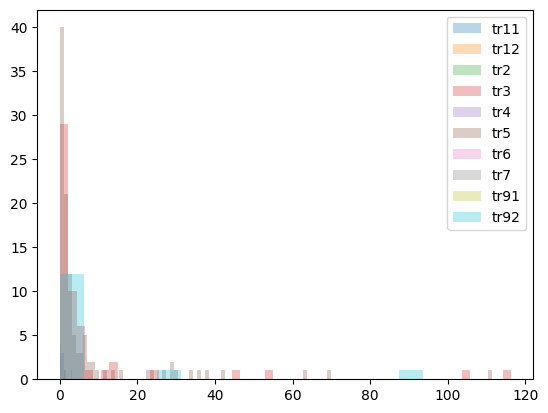

In [15]:
# Find hyperparameters for dt for each trajectory

for k, df in dfs_dict.items(): 
    dat_times = np.asarray(df['time'].values.tolist())
    dat_dt_times = np.diff(dat_times)

    uniq_dt, counts = np.unique(dat_dt_times.round(3), return_counts=True)

    plt.hist(uniq_dt, bins=uniq_dt.shape[0], label=k, alpha=0.3)
    print('for: ', k)
    print('Unique: ', uniq_dt)
    print('Counts: ', counts)
    print('-'*15)
plt.legend()
plt.show()

# tr11: 0.034, no outliers;
# tr12: 0.034, 3  outliers;
# tr2 : 0.034, no outliers;

# tr3 : 0.134, many nans and outliers, (high minimal sampling rate!);
# tr5 : 0.034, no nans and small outliers;
# tr6 : 0.034, no outliers, a lot of nans;
# tr7 : 0.034, no outliers, a lot of nans;
# tr91: 0.034, outliers, a lot of nans;
# tr92: 0.034, outliers, a lot of nans;

dt_threshold = 0.035  # dt values differnce that we count as normal (e.g. 0.133 and 0.134)

In [13]:
# Divide trajectory in sub-trajectories
traj_drop_threshold = 5

dt_thresholds = {'tr11': 0.035, 'tr12': 0.035, 'tr2': 0.035, 'tr3': 0.135, 'tr5': 0.035, # TODO: to configs
                 'tr6': 0.035, 'tr7': 0.035, 'tr91': 0.035, 'tr92': 0.035}
dfs_dict_with_subtraj = {}

for k, df in dfs_dict.items():

    # 1. Drop Nans
    df = df.dropna()

    # 2. Divide by time jumps
    dt_times = df['time'].diff().to_numpy()
    dt_times[0] = 0.

    div_idx = np.where(dt_times > dt_thresholds[k])[0]
    div_idx = np.asarray(div_idx)

    print(k, 'div_idx: ', div_idx, len(div_idx))

    if len(div_idx) > 0:
        div_idx = np.concatenate([np.array([0]), div_idx, np.array([len(df)])])

        sub_trajectories = []

        start_i = div_idx[0]
        for end_i in div_idx[1:]:

            # print(start_i, end_i)
            if end_i - start_i > traj_drop_threshold:

                sub_df = df[start_i:end_i]
                # print('YES: ', sub_df.shape)
                sub_trajectories.append(sub_df)

            start_i = end_i + 1

        print('sub_trajectories len: ', len(sub_trajectories))

        dfs_dict_with_subtraj[k] = sub_trajectories
    else:
        dfs_dict_with_subtraj[k] = df

    print('--'*30)

tr11 div_idx:  [] 0
------------------------------------------------------------
tr12 div_idx:  [22542 45421 45525] 3
sub_trajectories len:  4
------------------------------------------------------------
tr2 div_idx:  [] 0
------------------------------------------------------------
tr3 div_idx:  [  58   59   69   72   77  119  120  138  140  141  143  144  156  158
  197  199  200  202  203  207  212  214  263  283  314  336  340  385
  394  422  431  441  444  488  531  541  559  605  613  681  682  684
  718  724  769  770  807  831  910  913  922  943 1004 1006 1007 1050
 1155 1168 1173 1176 1223 1406 1410 1474 1492 1501 1522 1646 1647 1650
 1688 1709 1754 1892 1956 1960 1967 2109 2116 2120 2146 2262 2294 2485
 2497 2521 2605 2606 2642 2645 2652 2737 2781 2782 2876 2877 2971 3028
 3031 3041 3047 3049 3068 3086 3097 3131 3177 3197 3203 3240 3284 3335
 3342 3343 3392 3396 3397 3598 3606 3617 3739 3749 3752 3755 3765 3766
 3768 3804 3813 3902 3924 3927 3931 3999 4055 4073 4109 4176 41

112


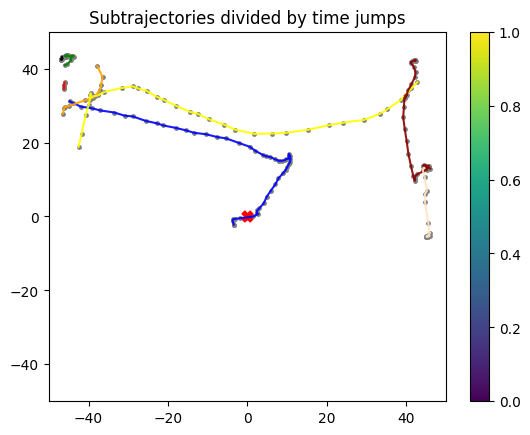

In [15]:
print(len(dfs_dict_with_subtraj['tr3']))

lines_colors = ['blue', 'red', 'green', 'black', 'orange',
                'yellow', 'darkred', 'bisque']
for i, sub_traj in enumerate(dfs_dict_with_subtraj['tr3']):
    x, y = sub_traj['x'], sub_traj['y']
    time_cmap = np.arange(0, len(x))
    plt.scatter(x, y, s=6, c='gray')
    plt.plot(x, y, alpha=0.9, c=lines_colors[i])

    if i > 6:
        break

plt.scatter(0, 0, marker='X', s=60, c='red')
plt.colorbar()
plt.xlim([-50, 50])
plt.ylim([-50, 50])
plt.title('Subtrajectories divided by time jumps')
plt.show()


In [16]:
## 2. Create function:
def divide_traj_by_nans(df, k, dt_threshold, traj_drop_threshold=5):
    # 1. Drop Nans
    df = df.dropna()
    # 2. Find if any time jumps
    dt_times = df['time'].diff().to_numpy()
    dt_times[0] = 0.
    div_idx = np.where(dt_times > dt_threshold)[0]
    div_idx = np.asarray(div_idx)

    # 3. Divide by time jumps
    if len(div_idx) > 0:
        div_idx = np.concatenate([np.array([0]),
                                  div_idx,
                                  np.array([len(df)])])
        sub_trajectories = []
        start_i = div_idx[0]
        for end_i in div_idx[1:]:
            if end_i - start_i > traj_drop_threshold:
                sub_df = df[start_i:end_i]
                sub_trajectories.append(sub_df)
            start_i = end_i + 1

        return k, sub_trajectories
    else:
        return k, df

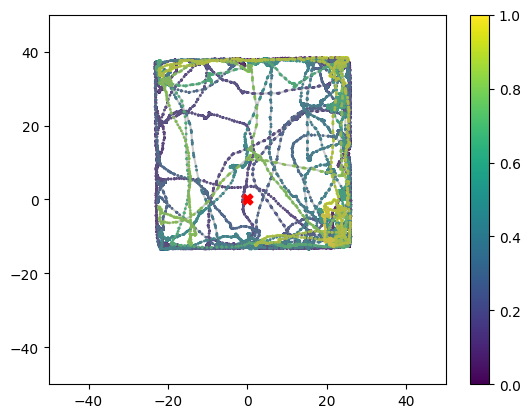

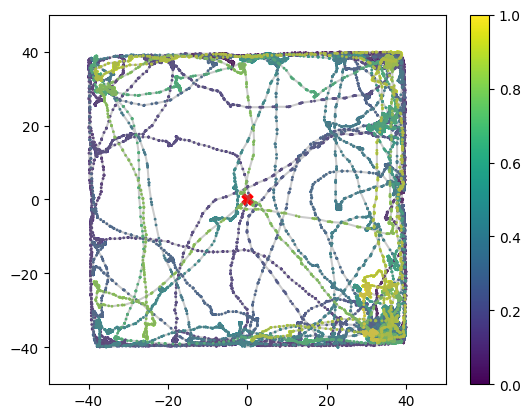

In [17]:
# 2.2. Rescale x and y coordinates to fit fixed area size
def rescale_coord(data, new_min, new_max):
    min_old_x, max_old_x = np.min(data), np.max(data)
    data_rescaled = ((data - min_old_x) / (max_old_x - min_old_x)) * (new_max - new_min) + new_min
    return data_rescaled

dff = dfs_dict['tr2'].copy()

plot_trajectory(dff['x'], dff['y'])
new_x = rescale_coord(dff['x'].to_numpy(), -40, 40)
new_y = rescale_coord(dff['y'].to_numpy(), -40, 40)

dff['x'] = new_x
dff['y'] = new_y
plot_trajectory(dff['x'], dff['y'])

In [40]:
# 3. Make resampling function, place it before all other functions, use after def divide_traj_by_nans()
import numpy as np
from scipy.signal import resample

def resample_data_to_larger_timestep(df, original_dt, new_dt):
    num_original_points = df.shape[0]
    duration = num_original_points * original_dt
    num_new_points = int(duration / new_dt)
    
    # Resample the data uresamplesing Fourier method
    resampled_dfnp = resample(df.to_numpy(), num_new_points, axis=0)
    resampled_df = pd.DataFrame({'time': resampled_dfnp[:, 0],
                                 'x': resampled_dfnp[:, 1], 
                                 'y': resampled_dfnp[:, 2]})
    return resampled_df


original_timestep = 0.034

# New desired larger dt
newdt = 0.3
dff = dfs_dict['tr11'].copy()
print('Old shape: ', dff.shape)

resampled_dat = resample_data_to_larger_timestep(dff, original_timestep, newdt)
resampled_dat.shape

Old shape:  (52568, 3)


(5957, 3)

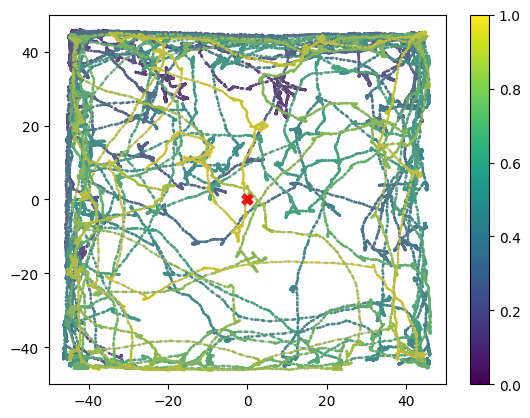

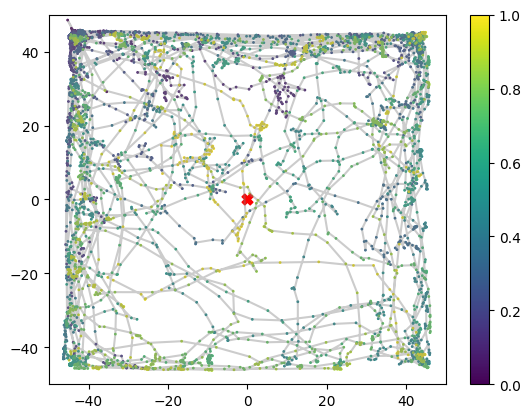

In [42]:
plot_trajectory(dff['x'], dff['y'])
plot_trajectory(resampled_dat['x'], resampled_dat['y'])